<a href="https://colab.research.google.com/github/myoshimu/tfp/blob/master/tfp.sts_ga360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 構造的時系列モデル(STS)
TensorFlow Probability（TFP）は現在、構造時系列モデルを使ったフィッティングや予測を標準でサポートしています。変分推論（VI）やハミルトニアン・モンテカルロ法（HMC）を使ったモデル パラメーターのベイズ推論などがサポートされており、点推定と不確かさの推定の両方を計算できます。TensorFlow を使って構築されているので、これらの手法はそのままでもベクトル ハードウェア（GPU や TPU）のメリットを活用でき、多くの時系列を効率的かつ並列に処理したり、ディープ ニューラル ネットワークと統合したりできます。

このノートブックでは、構造的な時系列の動きを見るために、Google Analytics の EC サイト月次訪問データを使用して時系列分析してみます。


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.sandbox.google.com/github/myoshimu/tfp/blob/master/tfp.sts_ga360.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/myoshimu/tfp/blob/master/tfp.sts_ga360.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### import modules

In [0]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

import collections

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

### plot 用関数定義

In [0]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast

  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2, label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, 
                  color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [0]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

### BQ データを参照する場合は以下を実行

In [0]:
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()
#@title プロジェクト変数の設定 { run: "auto", display-mode: "form" }
project_id = '' #@param {type:"string"}
#dataset_name = "cycle" #@param {type:"string"}
#eval_name = model_name + "_eval"
client = bigquery.Client(project=project_id)

In [0]:
#GA360時系列データ取得
query = """
SELECT
date,
SUM(totals.visits) visits,
SUM(totals.pageviews) pageviews,
SUM(totals.transactions) transactions,
SUM(totals.transactionRevenue)/1000000 revenue
FROM `bigquery-public-data.google_analytics_sample.*`
GROUP BY date
ORDER BY date asc
"""
df = client.query(query).to_dataframe()
df.head()

,date,visits,pageviews,transactions,revenue
0,20160801,1711,9843,34.0,6116.06
1,20160802,2140,11784,18.0,1361.19
2,20160803,2890,13724,NaN,NaN
3,20160804,3161,13326,17.0,1182.89
4,20160805,2702,13585,42.0,5594.26


### csvを参照する場合

In [147]:
df = pd.read_csv("https://raw.githubusercontent.com/myoshimu/tfp/master/ga360_sessions.csv", index_col=0)
df.index = pd.to_datetime(df.index, format='%Y%m%d')
df.head()

,visits,pageviews,transactions,revenue
date,,,,
2016-08-01,1711,9843,34.0,6116.06
2016-08-02,2140,11784,18.0,1361.19
2016-08-03,2890,13724,NaN,NaN
2016-08-04,3161,13326,17.0,1182.89
2016-08-05,2702,13585,42.0,5594.26


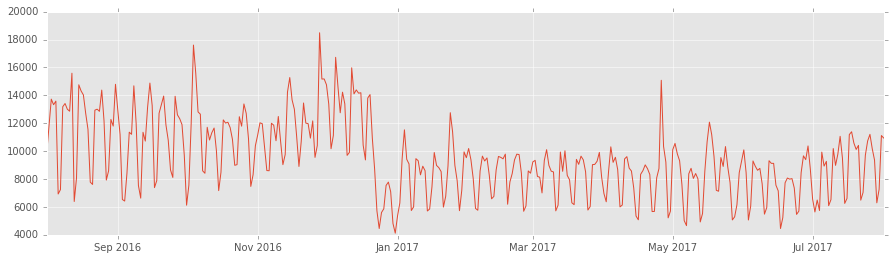

In [148]:
plt.style.use("ggplot")
plt.figure(figsize = (15, 4))

plt.plot(df.index, df.pageviews)
plt.show()

## ローカル線系トレンドモデル
### Model and Fitting
ローカル線形トレンド＋一週間(7日)ごとの季節的影響を加えてモデル化してみます。


In [0]:
#各種初期設定
plt.style.use("classic")
num_forecast_steps =30 # 一ヶ月分予測
views_by_month = np.array(df["pageviews"], dtype=np.float64)
training_data = views_by_month[:-num_forecast_steps]
dates=np.array(df.index,dtype="datetime64[D]")
#dates=df.index
loc = mdates.MonthLocator()  # matplotlib.datesで時系列データのグラフの軸目盛の設定（3年ごと）
fmt = mdates.DateFormatter('%Y%m') # 年だけ表示

In [0]:
def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal = tfp.sts.Seasonal(
      num_seasons=7, observed_time_series=observed_time_series)
  model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
  return model

変分推論(variational inference：未知パラメータをの平均をとる方法)を使用してモデルをfitし周期性やローカル線形トレンドの推定を行います。 これには、変動損失関数(variational loss function)であるネガティブエビデンス下限値（ELBO=evidence lower bound、確率分布間の距離の最小化を行う際に、許容できる誤差の最小値みたいなもの）を最小限に抑えるためのオプティマイザの実行が含まれます。これはパラメータに対する一連の近似事後分布に適合します。

In [185]:
tf.reset_default_graph()
model = build_model(training_data)

# 事後分布を指定
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      model,
      observed_time_series=training_data)


W0827 10:56:24.853144 140490457122688 linear_operator.py:940] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).


In [186]:
# 変分推論で変分損失を最小化
num_variational_steps = 201 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

train_vi = tf.train.AdamOptimizer(1).minimize(elbo_loss)
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(num_variational_steps):
    _, elbo_ = sess.run((train_vi, elbo_loss))
    if i % 20 == 0:
      print("step {} -ELBO {}".format(i, elbo_))

  # Draw samples from the variational posterior.
  q_samples_ga360_ = sess.run({k: q.sample(50)
                             for k, q in variational_posteriors.items()})



step 0 -ELBO 32883975.178543575
step 20 -ELBO 587239.9878450532
step 40 -ELBO 436297.0993985154
step 60 -ELBO 395525.1000641702
step 80 -ELBO 368985.6999455543
step 100 -ELBO 345846.7117172128
step 120 -ELBO 324854.40358048456
step 140 -ELBO 305862.9402560425
step 160 -ELBO 288730.26139494084
step 180 -ELBO 273295.9466473518
step 200 -ELBO 259362.54022267475
step 220 -ELBO 246780.12275491506
step 240 -ELBO 235364.13357640707
step 260 -ELBO 224975.716829184
step 280 -ELBO 215498.78502551623
step 300 -ELBO 206817.2872731846


In [187]:
#ローカル線形トレンドの切片と傾きの誤差（ノイズ）の範囲
print("Inferred parameters:")
for param in model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_ga360_[param.name], axis=0),
                              np.std(q_samples_ga360_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 14.955708516390644 +- 0.00012646615412928715
LocalLinearTrend/_level_scale: 13.840289601726777 +- 0.00020153840324120588
LocalLinearTrend/_slope_scale: 13.268137522960897 +- 0.00020484718645328857
Seasonal/_drift_scale: 13.370170238176447 +- 3.5038345120917324e-05


### 予測と評価

それでは、fitしたモデルを使って予測しましょう。 `tfp.sts.forecast`を呼び出すと、将来の予測分布を表すTensorFlow Distributionインスタンスを返します。
`tfp.sts`予測メソッドは入力として事後標本を必要とし、これにより変分事後分布（variational posterior）から一連のサンプルを引き出せます。

ここでは、トレンドが線形であると仮定した線形トレンドモデルを使用しました。ランダムウォークに従って時間の経過とともに勾配が緩やかに変化するモデルをデータに当てはめると、モデルの仮定に基づいて確率的予測が生成されます。

In [0]:
forecast_dist = tfp.sts.forecast(
    model,
    observed_time_series=training_data,
    parameter_samples=q_samples_ga360_,
    num_steps_forecast=num_forecast_steps)

予測分布の平均と標準偏差によって、各タイムステップの予測が得られます。また、将来おこりうるサンプルを抽出することもできます。

In [0]:
num_samples=100

with tf.Session() as sess:
  forecast_mean, forecast_scale, forecast_samples = sess.run(
      (forecast_dist.mean()[..., 0],
       forecast_dist.stddev()[..., 0],
       forecast_dist.sample(num_samples)[..., 0]))

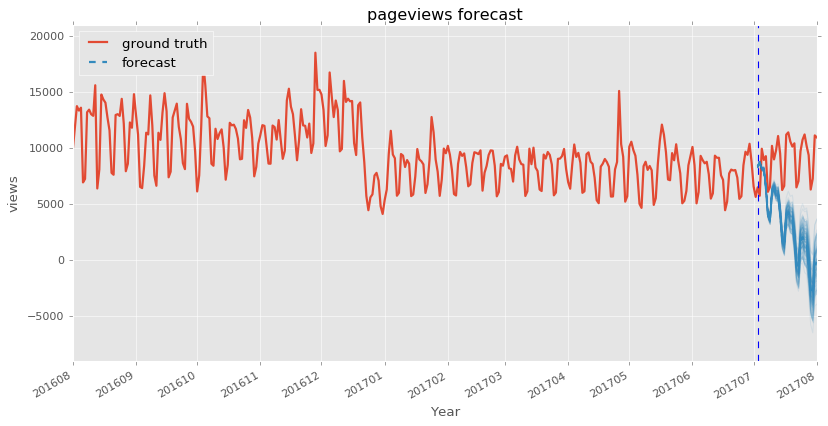

In [191]:
plt.style.use("ggplot")
fig, ax = plot_forecast(
    dates, views_by_month,
    forecast_mean, forecast_scale, forecast_samples,
    x_locator=loc,
    x_formatter=fmt,
    title="pageviews forecast")

ax.axvline(dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("views")
ax.set_xlabel("Year")
fig.autofmt_xdate()

実際よりかなり下向きのトレンドになってしまいました、、。はじめにデータを見て気づくべきでしたが、2017年1月に大幅にpageviewが減っているので、全体も下向きトレンドと認識されてしまったようです。ローカル線形トレンドだとこのような極端な変化の影響を受けてしまうので、以下のように1月以降のデータにするか他のモデルを検討したほうが良いかもしれません。

```
# 2017/1/1以降のデータにする
df = df["2017-01-01":]
```



## トレンドのないモデルに変更

1月の大幅な下落から、そもそもローカル線形トレンドが向いてなさそうなので、季節性だけを取り入れたモデルに変更してみます。

In [0]:
num_forecast_steps =30 # 一ヶ月分予測
views_by_month = np.array(df["pageviews"], dtype=np.float64)
training_data = views_by_month[:-num_forecast_steps]
dates=np.array(df.index,dtype="datetime64[D]")

In [0]:
#モデルを季節性だけに変更
def build_model(observed_time_series):
  seasonal = tfp.sts.Seasonal(
      num_seasons=7, observed_time_series=observed_time_series)
  model = sts.Sum([seasonal], observed_time_series=observed_time_series)
  return model

In [194]:
tf.reset_default_graph()
model = build_model(training_data)

# 事後分布を指定
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      model,
      observed_time_series=training_data)


W0827 11:17:47.737836 140490457122688 linear_operator.py:940] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).


In [195]:
model.parameters

[Parameter(name='observation_noise_scale', prior=<tfp.distributions.LogNormal 'Sum/LogNormal/' batch_shape=[] event_shape=[] dtype=float64>, bijector=<tensorflow_probability.python.bijectors.softplus.Softplus object at 0x7fc54aec5fd0>),
 Parameter(name='Seasonal/_drift_scale', prior=<tfp.distributions.LogNormal 'Seasonal/LogNormal/' batch_shape=[] event_shape=[] dtype=float64>, bijector=<tensorflow_probability.python.bijectors.softplus.Softplus object at 0x7fc55b2fe828>)]

In [196]:
# 変分推論で変分損失を最小化
num_variational_steps = 201 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

train_vi = tf.train.AdamOptimizer(1).minimize(elbo_loss)
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(num_variational_steps):
    _, elbo_ = sess.run((train_vi, elbo_loss))
    if i % 20 == 0:
      print("step {} -ELBO {}".format(i, elbo_))

  # Draw samples from the variational posterior.
  q_samples_ga360_ = sess.run({k: q.sample(50)
                             for k, q in variational_posteriors.items()})


step 0 -ELBO 505590054.6880009
step 20 -ELBO 11414516.513274303
step 40 -ELBO 5336526.46899905
step 60 -ELBO 3459682.5521967206
step 80 -ELBO 2586270.164641214
step 100 -ELBO 2730832.189505278
step 120 -ELBO 5530048.593342753
step 140 -ELBO 5507727.637568386
step 160 -ELBO 4659669.345662538
step 180 -ELBO 4074653.9430430806
step 200 -ELBO 1303723.103052104
step 220 -ELBO 2561534.874323385
step 240 -ELBO 3287792.647922917
step 260 -ELBO 2224946.7049896885
step 280 -ELBO 4502193.872169991
step 300 -ELBO 4301289.776620806
step 320 -ELBO 4135765.4020032515
step 340 -ELBO 3607996.5163279567
step 360 -ELBO 1902475.3672228358
step 380 -ELBO 1778266.3006365004
step 400 -ELBO 995308.6562218321
step 420 -ELBO 3522868.4627099955
step 440 -ELBO 3420101.3085453203
step 460 -ELBO 633687.4520235799
step 480 -ELBO 3154784.3737182994
step 500 -ELBO 1430292.2477192348


In [197]:
#ローカル線形トレンドの切片と傾きの誤差（ノイズ）の範囲
print("Inferred parameters:")
for param in model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_ga360_[param.name], axis=0),
                              np.std(q_samples_ga360_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 15.81132940338277 +- 0.012924209660150338
Seasonal/_drift_scale: 18.8246311931412 +- 25.214125867873694


In [0]:
forecast_dist = tfp.sts.forecast(
    model,
    observed_time_series=training_data,
    parameter_samples=q_samples_ga360_,
    num_steps_forecast=num_forecast_steps)

In [0]:
num_samples=100

with tf.Session() as sess:
  forecast_mean, forecast_scale, forecast_samples = sess.run(
      (forecast_dist.mean()[..., 0],
       forecast_dist.stddev()[..., 0],
       forecast_dist.sample(num_samples)[..., 0]))

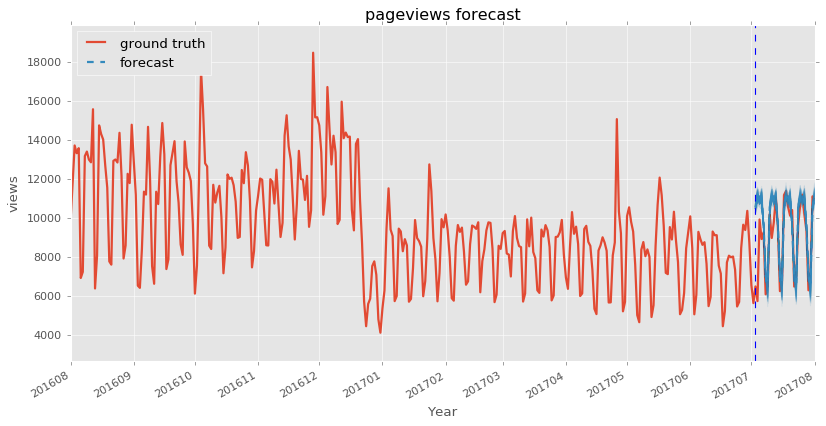

In [200]:
fig, ax = plot_forecast(
    dates, views_by_month,
    forecast_mean, forecast_scale, forecast_samples,
    x_locator=loc,
    x_formatter=fmt,
    title="pageviews forecast")

ax.axvline(dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("views")
ax.set_xlabel("Year")
fig.autofmt_xdate()

先程よりは予測と実測が近くなりました。

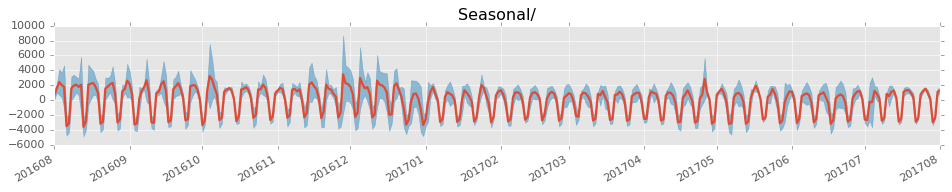

In [201]:
# 季節性シグナルをプロット
component_dists = sts.decompose_by_component(
    model,
    observed_time_series=views_by_month,
    parameter_samples=q_samples_ga360_)

with tf.Session() as sess:
  component_means_, component_stddevs_ = sess.run(
      [{k.name: c.mean() for k, c in component_dists.items()},
       {k.name: c.stddev() for k, c in component_dists.items()}])

_ = plot_components(dates, component_means_, component_stddevs_,
                    x_locator=loc, x_formatter=fmt)

## 回帰成分を取り入れたモデル
次にもう少し複雑なモデルを試してみましょう。月の季節性と自己回帰(AR)、visitsからpageviewを回帰する要素を追加してみます。

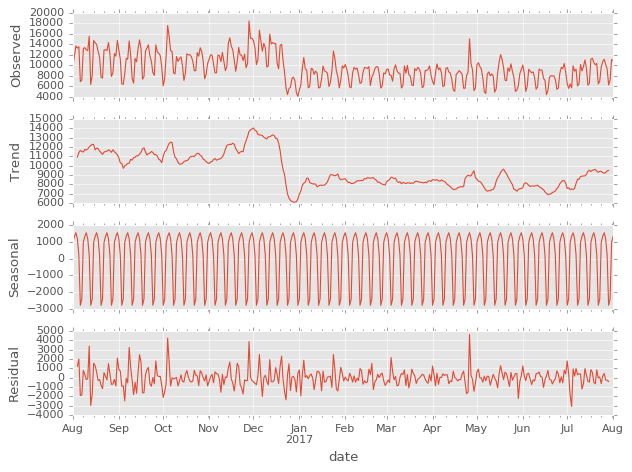

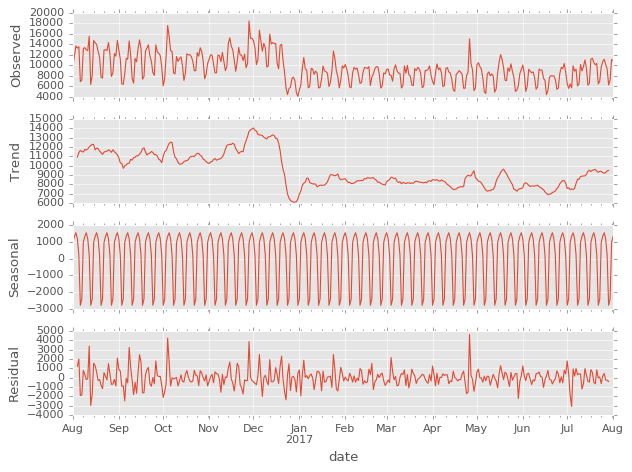

In [202]:
#statsmodelsでトレンドや季節性参照
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.pageviews)
result.plot()

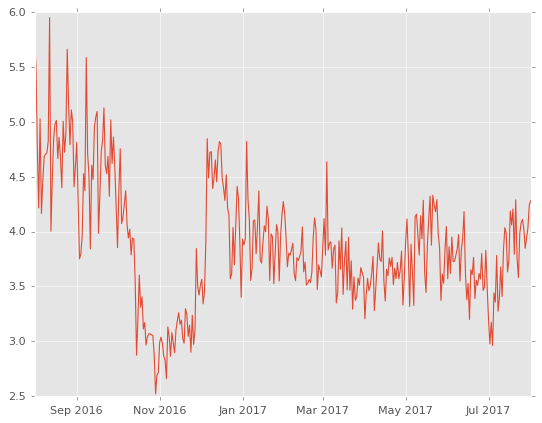

In [203]:
# 訪問あたりのページビュー
plt.plot(df.pageviews / df.visits)
plt.show()

In [0]:
visits = np.array(df["visits"], dtype=np.float64)
pageviews = np.array(df["pageviews"], dtype=np.float64)
pageviews_training_data = pageviews[:-num_forecast_steps]

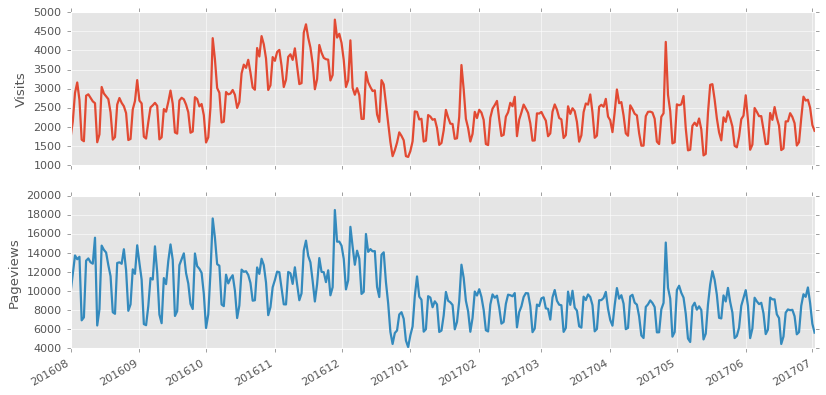

In [204]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dates[:-num_forecast_steps],
        visits[:-num_forecast_steps], lw=2, label="training data")
ax.set_ylabel("Visits")

ax = fig.add_subplot(2, 1, 2)

ax.plot(dates[:-num_forecast_steps],
        pageviews[:-num_forecast_steps], lw=2, label="training data", c=c2)
ax.set_ylabel("Pageviews")
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(fmt)
fig.autofmt_xdate()


In [0]:
def build_model(observed_time_series):
  month_effect = sts.Seasonal(
      num_seasons=12,
      observed_time_series=observed_time_series,
      name='month_effect')
  day_of_week_effect = sts.Seasonal(
      num_seasons=7, num_steps_per_season=24,
      observed_time_series=observed_time_series,
      name='day_of_week_effect')
  visit_effect = sts.LinearRegression(
      design_matrix=tf.reshape(views_by_month - np.mean(views_by_month),
                               (-1, 1)), name='visit_effect')
  #AR(1)成分
  autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series,
      name='autoregressive')
  model = sts.Sum([month_effect,
                   day_of_week_effect,
                   visit_effect,
                   autoregressive],
                   observed_time_series=observed_time_series)
  return model

In [172]:
tf.reset_default_graph()
regression_model = build_model(pageviews_training_data)

# Build the variational loss function and surrogate posteriors `qs`.
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      regression_model, pageviews_training_data)
train_vi = tf.train.AdamOptimizer(0.1).minimize(elbo_loss)

W0827 10:00:56.311135 140490457122688 linear_operator.py:940] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).
W0827 10:00:56.397897 140490457122688 linear_operator.py:940] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).


In [173]:
# 最適化を実行し、事後分布からサンプルを描画
num_variational_steps = 201  # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for i in range(num_variational_steps):
    _, elbo_ = sess.run((train_vi, elbo_loss))
    if i % 20 == 0:
      print("step {} -ELBO {}".format(i, elbo_))

  q_samples_pageviews_ = sess.run({k: q.sample(50)
                                for k, q in variational_posteriors.items()})

step 0 -ELBO 80111391.70481512
step 20 -ELBO 2400345.416171254
step 40 -ELBO 54544.1350568247
step 60 -ELBO 77408.6867107863
step 80 -ELBO 1660.4532356369566
step 100 -ELBO 2931.6789123765925
step 120 -ELBO 26352.425301048814
step 140 -ELBO 9880.14299414985
step 160 -ELBO 6567.116920584461
step 180 -ELBO 1829.5683387290094
step 200 -ELBO 10191.304788781286


In [174]:
print("Inferred parameters:")
for param in regression_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_pageviews_[param.name], axis=0),
                              np.std(q_samples_pageviews_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 2.090945935294386 +- 0.00527385691768288
month_effect/_drift_scale: 3.1567719364916824 +- 0.0424341763786691
day_of_week_effect/_drift_scale: 1.888561084392248 +- 0.025021644272623437
visit_effect/_weights: [0.98296346] +- [0.01685904]
autoregressive/_coefficients: [0.87732511] +- [0.00468352]
autoregressive/_level_scale: 3.4026787978635618 +- 0.010629119616489715


### 予測と評価

In [0]:
pageviews_forecast_dist = tfp.sts.forecast(
    model=regression_model,
    observed_time_series=pageviews_training_data,
    parameter_samples=q_samples_pageviews_,
    num_steps_forecast=num_forecast_steps)

In [0]:
num_samples=100

with tf.Session() as sess:
  (pageviews_forecast_mean,
   pageviews_forecast_scale,
   pageviews_forecast_samples) = sess.run(
      (pageviews_forecast_dist.mean()[..., 0],
       pageviews_forecast_dist.stddev()[..., 0],
       pageviews_forecast_dist.sample(num_samples)[..., 0]))

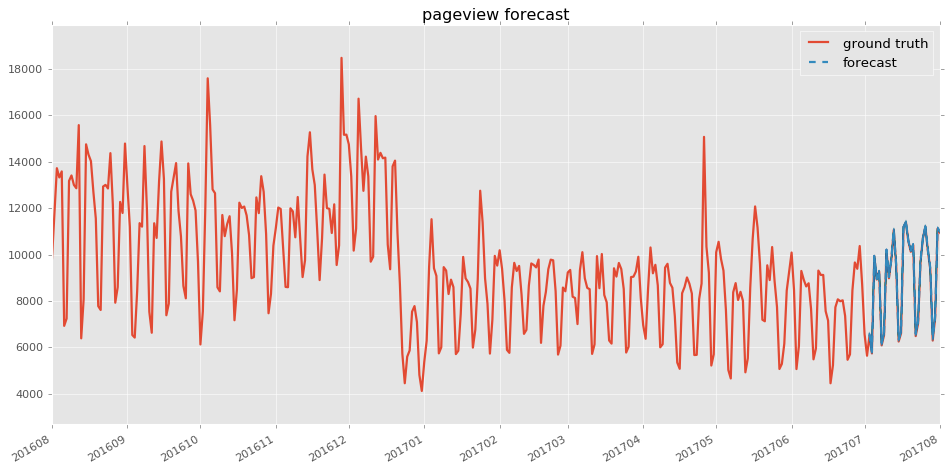

In [205]:
fig, ax = plot_forecast(dates, pageviews,
                        pageviews_forecast_mean,
                        pageviews_forecast_scale,
                        pageviews_forecast_samples,
                        title="pageview forecast",
                        x_locator=loc, x_formatter=fmt)
#ax.set_ylim([0, 10])
fig.tight_layout()

In [0]:
# トレーニングデータの事後周辺分布および予測モデルからコンポーネント出力の分布を取得
component_dists = sts.decompose_by_component(
    regression_model,
    observed_time_series=pageviews_training_data,
    parameter_samples=q_samples_pageviews_)

forecast_component_dists = sts.decompose_forecast_by_component(
    regression_model,
    forecast_dist=pageviews_forecast_dist,
    parameter_samples=q_samples_pageviews_)

In [0]:
with tf.Session() as sess:
  pageviews_component_means_, pageviews_component_stddevs_ = sess.run(
      [{k.name: c.mean() for k, c in component_dists.items()},
       {k.name: c.stddev() for k, c in component_dists.items()}])

  [
      pageviews_forecast_component_means_,
      pageviews_forecast_component_stddevs_
  ] = sess.run(
      [{k.name: c.mean() for k, c in forecast_component_dists.items()},
       {k.name: c.stddev() for k, c in forecast_component_dists.items()}])

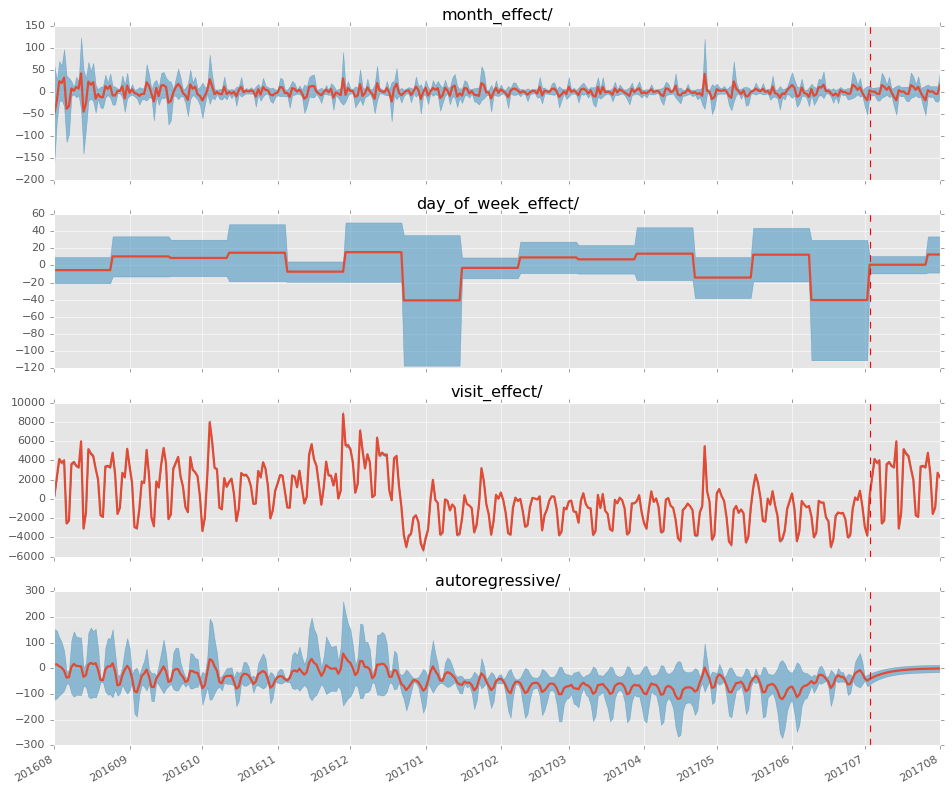

In [206]:
# トレーニングデータをプロットの予測と結合
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in pageviews_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      pageviews_component_means_[k],
      pageviews_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      pageviews_component_stddevs_[k],
      pageviews_forecast_component_stddevs_[k]], axis=-1)


fig, axes = plot_components(
  dates,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=loc, x_formatter=fmt)
for ax in axes.values():
  ax.axvline(dates[-num_forecast_steps], linestyle="--", color='red')